In [1]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor

from sklearn.utils import shuffle
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import GridSearchCV

import math
import numpy as np
import random
import logging
import numbers

In [2]:
random_state = 20
epsilon = 0.1
machine_list = ['RSF','DeepHit','MLTR','Cox_Time']   
n_patients = 312

In [3]:
# Import Predictions
import pickle
"""Dictionaries of the form {'patient_id':'Predictions_array'}"""
rsf_predictions = pickle.load( open( "patient_surv_functions/rsf.p", "rb" ) )
deep_hit_predictions = pickle.load( open( "patient_surv_functions/deep_hit.p", "rb" ) )
mltr_predictions = pickle.load( open( "patient_surv_functions/mltr.p", "rb" ) )
cox_time_predictions = pickle.load( open( "patient_surv_functions/cox_time.p", "rb" ) )

In [4]:
# Timepoints taken in considerations format : float
event_time = [  8.,  11.,  16.,  20.,  26.,  27.,  29.,  30.,  31.,  32.,  38.,
        44.,  47.,  50.,  56.,  74.,  76.,  79.,  89.,  96.,  99., 101.,
       105., 109., 112., 114., 118., 120., 122., 125., 127., 129., 133.,
       134., 135., 139., 143., 145., 148., 152., 154., 155., 165., 166.,
       167., 170., 173., 185., 186., 193., 194., 201., 204., 205., 206.,
       213., 215., 219., 220., 235., 236., 239., 241., 248., 255., 261.,
       263., 264., 267., 271., 275., 278., 285., 287., 292., 293., 297.,
       298., 303., 317., 322., 328., 332., 335., 336., 340., 345., 353.,
       357., 362., 364., 368., 370., 395., 399., 411., 438., 440., 441.,
       459., 462., 468., 482., 484., 489., 491., 511., 525., 536., 547.,
       549., 556., 597.]

In [5]:
def load_machine_predictions(machine_list,time):
    """
    TODO rewrite this\\\///
    Stores the trained machines' predicitons on training data in a dictionary, to be used for predictions.
    Should be run after all the machines to be used for aggregation is loaded.
    Parameters
    ----------
    predictions: dictionary, optional
        A pre-existing machine:predictions dictionary can also be loaded.
    Returns
    -------
    self : returns an instance of self.
    """
    machine_predictions_ = {}
    all_predictions_ = np.array([])
    for machine in machine_list:
        if machine == 'RSF':
            surv_probablity = np.zeros(n_patients)
            for id in range(n_patients):
                surv_probablity[id] = deep_hit_predictions[id][time]
            machine_predictions_[machine] = surv_probablity
        if machine == 'DeepHit':
            surv_probablity = np.zeros(n_patients)
            for id in range(n_patients):
                surv_probablity[id] = deep_hit_predictions[id][time]
            machine_predictions_[machine] = surv_probablity
        if machine == 'MLTR':
            surv_probablity = np.zeros(n_patients)
            for id in range(n_patients):
                surv_probablity[id] = mltr_predictions[id][time]
            machine_predictions_[machine] = surv_probablity
        if machine == 'Cox_Time':
            surv_probablity = np.zeros(n_patients)
            for id in range(n_patients):
                surv_probablity[id] = cox_time_predictions[id][time]
            machine_predictions_[machine] = surv_probablity        
        # all_predictions_ is used in the diagnostics class, and for initialising epsilon
        all_predictions_ = np.append(all_predictions_, machine_predictions_[machine])

    return machine_predictions_,all_predictions_

In [6]:
mp,ap = load_machine_predictions(machine_list,0)

In [7]:
np.shape(ap)

(1248,)

In [8]:
def get_points(patient_id,time,epsilon, alpha = 4,info = True):
    """
    Performs the COBRA aggregation scheme, used in predict method.
    Parameters
    ----------
    X: array-like, [n_features]
    alpha: int, optional
        alpha refers to the number of machines the prediction must be close to to be considered during aggregation.
    info: boolean, optional
        If info is true the list of points selected in the aggregation is returned.
    Returns
    -------
    avg: prediction
    """

    # dictionary mapping machine to points selected
    select = {}
    machine_predictions, all_predictions = load_machine_predictions(machine_list,time)
    for machine in machine_list:
        # machine prediction
        val = machine_predictions[machine][patient_id]
#         val = self.estimators_[machine].predict(X)
        select[machine] = set()
        # iterating from l to n
        # replace with numpy iteration
        for count in range(0, n_patients):
            try:
                # if value is close to prediction, select the indice
                if math.fabs(machine_predictions[machine][count] - val) <= epsilon:
                    select[machine].add(count)
            except (ValueError, TypeError) as e:
                logger.info("Error in indice selection")
                continue

    points = []
#     # count is the indice number.
    for count in range(0, n_patients):
        # row check is number of machines which picked up a particular point
        row_check = 0
        for machine in select:
            if count in select[machine]:
                row_check += 1
        if row_check <= alpha:
            points.append(count)

#     # if no points are selected, return 0
#     if len(points) == 0:
#         if info:
#             logger.info("No points were selected, prediction is 0")
#         return machine_predictions['deep_hit'][patient_id]

#     # aggregate
#     avg = 0
#     for point in points:
#         avg += self.y_l_[point]
#     avg = avg / len(points)

#     if info:
#         return avg, points
    return points

In [9]:
# get_points(0,0,0.001,1,True)

In [10]:
def agregate(patient_id,time,epsilon, alpha = 4,info = True, test = False):
    points = get_points(patient_id,time,epsilon, alpha,info = True)
    avg = 0
    machine_predictions, all_predictions = load_machine_predictions(machine_list,time)
    for point in points:
        for machines in machine_predictions:
            avg += machine_predictions[machines][point]
    
    avg = avg / (len(points)*alpha)
    if test:
        for machine in machine_predictions:
            print(machine, machine_predictions[machine][patient_id])
    return avg
        

In [11]:
agregate(0,0,0.001,4,True)

0.9915038197895598

In [12]:
# Get cobra predictions
def cobra_surv(patient_id, epsilon, alpha = 4):
    cobra_predictions = np.zeros(len(event_time)) 
    for time in range(len(event_time)):
        cobra_predictions[time] = agregate(patient_id,time, epsilon,alpha)
    return cobra_predictions

In [13]:
cobra_predictions = cobra_surv(1, 0.001, alpha = 4)

In [14]:
cobra_predictions

array([0.99150382, 0.98736883, 0.98287452, 0.97769382, 0.97291768,
       0.97026239, 0.96664863, 0.9619245 , 0.96061173, 0.95774009,
       0.95351998, 0.95114995, 0.94840296, 0.94350679, 0.939226  ,
       0.93153486, 0.92777517, 0.92386688, 0.91748203, 0.91364603,
       0.90987472, 0.90576664, 0.9046759 , 0.89517109, 0.88983415,
       0.88800514, 0.88364099, 0.88322668, 0.88162302, 0.87933748,
       0.877785  , 0.87640334, 0.87338589, 0.87319   , 0.86865839,
       0.86727797, 0.86074352, 0.85535359, 0.84995762, 0.84880953,
       0.84759177, 0.84512395, 0.84112279, 0.83745057, 0.83360606,
       0.83023567, 0.82980311, 0.81054452, 0.81025574, 0.80970724,
       0.80924378, 0.80633437, 0.80430622, 0.79932369, 0.7987385 ,
       0.7895407 , 0.78584636, 0.78087231, 0.77663293, 0.77088562,
       0.76999042, 0.76847811, 0.75522901, 0.74986852, 0.74278856,
       0.73754822, 0.73679287, 0.73343544, 0.73120945, 0.72650036,
       0.7233685 , 0.71974668, 0.71860761, 0.71596403, 0.70418

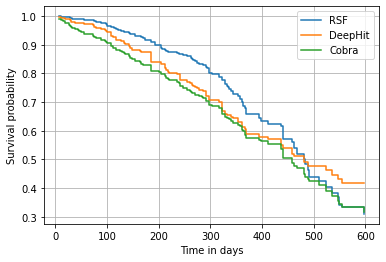

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


plt.step(event_time, rsf_predictions[1], where="post", label=str('RSF'))
plt.step(event_time, deep_hit_predictions[1], where="post", label=str('DeepHit'))
plt.step(event_time, cobra_predictions, where="post", label=str('Cobra'))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [25]:
def cobra_plot(patient_id, epsilon, alpha = 4):
    cobra_predictions = np.zeros(len(event_time)) 
    for time in range(len(event_time)):
        cobra_predictions[time] = agregate(patient_id,time, epsilon,alpha)
    plt.step(event_time, rsf_predictions[patient_id], where="post", label=str('RSF'))
    plt.step(event_time, deep_hit_predictions[patient_id], where="post", label=str('DeepHit'))
    plt.step(event_time, mltr_predictions[patient_id], where="post", label=str('MLTR'))
    plt.step(event_time, cox_time_predictions[patient_id], where="post", label=str('Cox_Time'))
    plt.step(event_time, cobra_predictions, where="post", label=str('Cobra'))
    plt.ylabel("Survival probability")
    plt.xlabel("Time in days")
    plt.legend()
    plt.grid(True)

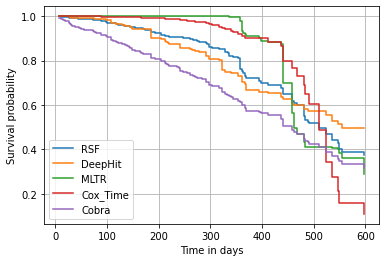

In [28]:
cobra_plot(5, 0.0001, alpha = 4)